#Assignment 2 - Transliteration

In this task you are required to solve the transliteration problem of names from English to Russian. Transliteration of a string means writing this string using the alphabet of another language with the preservation of pronunciation, although not always.


## 0. Instructions

To complete the assignment please do the following  steps (all the three are requred to get the full credits): 

1. **Notebook**. Upload to Canvas a filled notebook with answers (this file). 
Please enter the questions inside this notebook where appropriate in the designated cells.

2. **Scripts**. In *Practical* part of this notebook you will be asked to implement a transformer-based approach for transliteration. Upload to Canvas your code which implements solution to this part in the form of *.py file (not *.ipynb notebooks) of the model:

  - ``translit.py`` 

This script should have the specific structure as it is shown in the baseline soultion [here](https://github.com/skoltech-nlp/filimdb_evaluation/blob/master/translit_baseline.py). So, you should implement your ``train`` and ``classify`` functions. Your model should be implemented as a special class/function in this script (be sure if you add any outer dependencies that everything is improted correctly and can be reproducable). 

Please make sure that you code does not contain any dependencies which are specific to your system.

  *Important*: to make sure everything works, please use ONLY the following software configuration (no matter which operating system you use): Anaconda 2020.07  distribution for Python 3.8 and PyTorch 1.3. The preferred way to install PyTorch is "conda install -c pytorch pytorch" and Torchtext is "conda install -c pytorch torchtext". There should be no additional libraries used: Anaconda already provides a sufficient number of them. If you need something just select from these available. Test for no the absence of dependencies by creating a virtual environment. 

3. **Shared task.** After the implementation of models' architectures you are asked to participate in the [competition](https://competitions.codalab.org/competitions/30932) to solve **Transliteration** task using your implemented code. 

You should use your transliteration scripts from the previous part to train, validate, and generate predictions for the public (Practice) and private (Evaluation) test sets. For this you should use [``evaluate_translit.py``](https://github.com/skoltech-nlp/filimdb_evaluation/blob/master/evaluate_translit.py) script. 

It will produce predictions (``preds_translit.tsv``) for the dataset and score them if the true answers are present. You can use these scores to evaluate your model on dev set and choose the best one. Be sure:

1. To download the [dataset](https://github.com/skoltech-nlp/filimdb_evaluation/blob/master/TRANSLIT.tar.gz) and unzip it in the same folder where ``evaluate_translit.py`` is.
2. to put your ``translit.py`` and ``evaluate_translit.py`` scripts in the same folder. 
3. to change importing in ``evaluate_translit.py`` from ``translit_baseline`` import ``train, classify`` to ``from translit import train, classify``.

If you work in Colab you can dowload data and scripts with ``wget`` command and run them from notebook cells. 

Upload obtained TSV file with your predictions (``preds_translit.tsv``) in ``.zip`` for the best results to both phases of the competition.

Please, provide here in the notebook your user name in Codalab competition that we can recognize you in the leaderboard.


**YOUR USERNAME IN THE CODALAB LEADERBOARD:**

```

annakey

```

##1. Theoretical part
Solve the following theoretical subtasks:


###1.1 Normalization

* The main part of transformer architecture is MultiHeadAttention. This layer is breafly explained in subsection 2.2, its logic is described with formulas:
$$
Attention(Q, K, V)=softmax\left(\frac{Q K^{T}}{\sqrt{d_{k}}}\right) V
$$
$$
MultiHead(Q, K, V) = Concat\left(head_1, ..., head_h\right) W^O \\
$$
$$
head_i = Attention \left(Q W_i^Q, K W_i^K, V W_i^V\right)
$$
$h$ - the number of attention heads - parallel sub-layers for Scaled Dot-Product Attention on a vector of smaller dimension ($d_{k} = d_{q} = d_{v} = d_{model} / h$). 
Explain your thoughts: what the reason of deviding before $softmax$ the elements of $QK^{T}$ by $\sqrt{d_{k}}$\,?
($d_k = d_{model} / h$ - dimentionality of vectors-keys, queries and values, $d_{model}$ - dimentionality of inout and output vectors at all layers, $h$ - number of attention heads).
What problems can arise making training less stable without devision by $\sqrt{d_{k}}$ and working with large $d_{model}$?


__Answer:__ 

Vaswani et al.: “We suspect that for large values of $d_k$, the dot products grow large in magnitude, pushing the $softmax$ function into regions where it has extremely small gradients”. Therefore, to avoid gradient vanishing problem we need to divide dot product by $\sqrt{d_{k}}$.

The main idea is the same as in FFNN:
if inputs have zero mean and unit variance,
activations in each layer should have them also.
After random init $w \sim N(0,1)$: $Var(wx) = d Var(w) Var(x)$. Hence, to save variance of the input we should use $w \sim N(0,1/d)$. Why we need to save variance?

If the variance of the inputs of $softmax$ is too high (when we work with large $d_model$) the output of the $softmax$ will be similar to he one-hot vector. Some values will be almost equal to $1$ while the other will be almost equal to $0$. In this case the gradient of the $softmax$ function will be almost equal to zero. Therefore, gradients will not flow to the next layers during the backward pass. And we want to avoid it and prevent the gradient vanishing problem. Hence, we need to do this division.

###1.2 Complexity



* Let the input of Transformer be the sequence of $n$ tokens. Before been processed by MultiHeadAttention layer (MHA) it corresponds to the sequence of vectors $x_{1} \ldots x_{n}$. Output from this layer -- if the sequence of vectors $y_{1} \ldots y_{n}$, vectors can be packed in a matrix $Y$ and be denoted with formula $Y = \mathbf{MHA}(x_{1} \ldots x_{n})$.
Imagine now that there is a hidden layer of a recurrent neural network that performs a transformation similar to the type of input and output $y_{i} = \mathbf{RecurrentLayer}(x_{1} \ldots x_{i})$.
Let us introduce the function $path(i,j)$, which denotes the number of applications of various operations on the path of creating a vector $y_{j}$ from a sequence $x_{i} \ldots x_{j}$. In terms of O-big $O(\cdot)$, dependent from  $n$ describe, what equals $path(1,n)$ for recurrent layer and  MultiHeadAttention layer. 
e.x. $O(n\log(n)),O(n^{2}),O(1)$



__Answer:__ 

__Self-Attention__  (taken from https://stackoverflow.com/questions/65703260/computational-complexity-of-self-attention-in-the-transformer-model)

X is an input to a self-attention layer, it has the shape $(n, d)$ since there are $n$ word-vectors (corresponding to rows) each of dimension $d$. 

To compute the output of self-attention we need to perform the following steps (consider single-headed self-attention for simplicity): firstly, we need to compute the query $Q$, key $K$, and value $V$ matrices, each of which has shape $(n, d)$. This is accomplished by post-multiplying $X$ with $3$ learned matrices of shape $(d, d)$, amounting to a computational complexity of $O(n d^2)$. Secondly, we need to compute the layer output, $SoftMax(Q K_t / sqrt(d)) V$, where the softmax is computed over each row. Computing $Q K_t$ has complexity $O(n^2 d)$, and post-multiplying the resultant with V has complexity $O(n^2 d)$ as well. Finally, the total complexity is $O(n^2 d + n d^2)$.

__RNN__

Let's assume that the sizes of embeddings and hidden layers are the same and equal to $d$. And inside the hidden layer there is one projection matrix $ W $ of size $ d *d. $ At each step we multiply the input embedding vector and the projection matrix and apply the activation function. The total complexity of these operations is $O(d^2)$. And we repeat it at each step. We have &n& timesteps. Hence, the complexity is $O(nd^2)$.




###1.3 Mask


The mask is applied to the weights of MultiHeadAttention in transformer before computing the weighted sum of value-vectors. Describe what types of masks are usually used.

__Answer:__ taken from  https://towardsdatascience.com/transformers-explained-65454c0f3fa7

There are two kinds of masks used in the multi-head attention mechanism of the Transformer.

Padding Mask: The input vector of the sequences is supposed to be fixed in length. Hence, a max_length parameter defines the maximum length of a sequence that the transformer can accept. All the sequences that are greater in length than max_length are truncated while shorter sequences are padded with zeros. The zero-paddings, however, are not supposed to contribute to the attention calculation nor in the target sequence generation. The working of padding mask is explained in the adjacent figure. This is an optional operation in the Transformer.

Look-ahead Mask: While generating target sequences at the decoder, since the Transformer uses self-attention, it tends to include all the words from the decoder inputs. But, practically this is incorrect. Only the words preceding the current word may contribute to the generation of the next word. Masked Multi-Head Attention ensures this. 

### 1.4 Positional encoding 

As you remember, Transformer treats an input sequence of elements as a time series. Since the Encoder inside the Transformer simultaneously processes the entire input sequence, the information about the position of the element needs to be encoded inside its embedding, since it is not identified in any other way inside the model. That is why the PositionalEncoding layer is used, which sums embeddings with a vector of the same dimension.
Let the matrix of these vectors for each position of the time series be denoted as $PE$. Then the elements of the matrix are:

$$ PE_{(pos,2i)} = \sin{(pos/10000^{2i/d_{model}})}$$
$$ PE_{(pos,2i+1)} = \cos{(pos/10000^{2i/d_{model}})}$$

where $pos$ - is the position, $i$ - index of the component of the corresponging vector, $d_{model}$ - dimension of each vector. Thus, even components represent sine values, and odd ones represent cosine values with different arguments.

***Task:*** propose ANOTHER way of positional encoding. Describe pros and cons of your method comparing to the described above.


__Answer:__ In this paper tree-based method is proposed: https://proceedings.neurips.cc/paper/2019/file/6e0917469214d8fbd8c517dcdc6b8dcf-Paper.pdf .

"In this work, we generalize transformers to embed tree representations. Our work introduces novel
positional encodings for tree-structured data
. Using these encodings, we can apply transformers to
tree-structured domains, allowing information to percolate fully across the graph in a single layer.
This can potentially extend the transformer to settings ranging from natural language parse trees
to program abstract syntax trees. We evaluate our tree-transformers on programming language
translation tasks."

". In the context of sequences, the
relationship between two positions is simply the distance j that separates them. For trees though,
the relation between two nodes is a path: a series of steps along tree branches."

"Therefore, our desired property is that for all paths $\phi$, there is a corresponding affine transform in the positional space $A_{\phi}$ that captures the same relationship. Specifically, if $a$ and $b$ are two positions in a tree such that the path between them is $\phi$, then we desire the following:
$$
P E_{b}=A_{\phi} P E_{a}
$$
This allows the transformer to learn path-wise relationships within its embedding layers."

The main advantage of the proposed method is that it can work with the tree-structured data. Moreover, "The tree-transformer demonstrates advantages over both the sequence-transformer and tree2tree LSTM."

##2. Practical part

###2.1 Basic algorithm

In the  https://github.com/skoltech-nlp/filimdb_evaluation  there is a dataset and the baseline -- translit\_baseline.py. The basic algorithm is based on the following idea: for transliteration, alphabetic n-grams from one language can be transformed into another language into n-grams of the same size, using the most frequent transformation rule found according to statistics on the training sample. To test the implementation, clone the repository, unzip the datasets, and run the evaluation script. To do this, you need to run the following commands:
* `git clone https://github.com/skoltech-nlp/filimdb_evaluation.git`
* `cd filimdb_evaluation`
* `./init.sh translit`
* `python evaluate_translit.py`


###2.2  Transformer-based approach


To implement YOUR algorithm, use the template code, which needs to be modified.

Files to be used:
* `translit.py` - the main file where you need to make changes to be uploaded.
* `test_implementation.py` - file for testing the modules that you will need to implement as part of this task.
* `translit_utils` - folder with two `.py` files, which implements the logic of working with data and counting metrics.
First, you need to add some details in the code of the Transformer architecture, implement the methods of the class `LrScheduler`, which is responsible for updating the learning rate during training.
Next, you need to select the hyperparameters for the model according to the proposed guide.


Script `translit.py` contains the following elements:

* architecture of the Transformer as a class inheriting `torch.nn.Module`;
* algorithm of learning and classification in the form of  functions train and classify. Two these functions are the most important in this script.


####2.2.1  Positional Encoding

As you remember, Transformer treats an input sequence of elements as a time series. Since the Encoder inside the Transformer simultaneously processes the entire input sequence, the information about the position of the element needs to be encoded inside its embedding, since it is not identified in any other way inside the model. That is why the PositionalEncoding layer is used, which sums embeddings with a vector of the same dimension.
Let the matrix of these vectors for each position of the time series be denoted as $PE$. Then the elements of the matrix are:

$$ PE_{(pos,2i)} = \sin{(pos/10000^{2i/d_{model}})}$$
$$ PE_{(pos,2i+1)} = \cos{(pos/10000^{2i/d_{model}})}$$

where $pos$ - is the position, $i$ - index of the component of the corresponging vector, $d_{model}$ - dimension of each vector. Thus, even components represent sine values, and odd ones represent cosine values with different arguments.

In this task you are required to implement these formulas inside the class constructor *PositionalEncoding* in the main file ``translit.py``, which you are to upload. To run the test use the following command:

`python test_implementation.py test_positional_encoding`

Make sure that there is no any `AssertionError`!


In [ ]:
!python translit.py test_positional_encoding

####2.2.2  MultiHeadAttention


Then you are required to implement `attention` method in the class  `MultiHeadAttention`. The MultiHeadAttention layer takes as input  query vectors, key and value vectors for each step of the sequence of matrices  Q,K,V correspondingly. Each key vector, value vector, and query vector is obtained as a result of linear projection using one of three trained vector parameter matrices from the previous layer. This semantics can be represented in the form of formulas:
$$
Attention(Q, K, V)=softmax\left(\frac{Q K^{T}}{\sqrt{d_{k}}}\right) V\\
$$

$$
MultiHead(Q, K, V) = Concat\left(head_1, ... , head_h\right) W^O\\
$$

$$
head_i=Attention\left(Q W_i^Q, K W_i^K, V W_i^V\right)\\
$$
$h$ - the number of attention heads - parallel sub-layers for Scaled Dot-Product Attention on a vector of smaller dimension ($d_{k} = d_{q} = d_{v} = d_{model} / h$). 
The logic of  \texttt{MultiHeadAttention} is presented in the picture (from original  [paper](https://arxiv.org/abs/1706.03762)):

![](https://lilianweng.github.io/lil-log/assets/images/transformer.png)


Inside a method `attention` you are required to create a dropout layer from  MultiHeadAttention class constructor. Dropout layer is to be applied directly on the attention weights - the result of softmax operation. Value of drop probability  can be regulated in the train in the `model_config['dropout']['attention']`.

The correctness of implementation can be checked with
`test_implementation.py`:

```
python test_implementation.py test_multi_head_attention
```


In [ ]:
!python translit.py test_multi_head_attention

####2.2.3  LrScheduler

The last thing you have to prepare is the class  `LrScheduler`, which is in charge of  learning rate updating after every step of the optimizer. You are required to fill the class constructor and the method `learning_rate`. The preferable stratagy of updating the learning rate (lr), is the following two stages:

* "warmup" stage - lr linearly increases until the defined value during the fixed number of steps (the proportion of all training steps - the parameter `train_config['warmup\_steps\_part']` in the train function). 
* "decrease" stage - lr linearly decreases until 0 during the left training steps.

`learning_rate()` call should return the value of  lr at this step,  which number is stored at self.step. The class constructor takes not only `warmup_steps_part` but the peak learning rate value `lr_peak` at the end of "warmup" stage and a string name of the strategy of learning rate scheduling. You can test other strategies if you want to with `self.type attribute`. 

Correctness check:

```
python test_implementation.py test_lr_scheduler
```


In [ ]:
!python translit.py test_lr_scheduler

###2.3  Hyper-parameters choice

The model is ready. Now we need to find the optimal hyper-parameters.

In the repository in the TRANSLIT directory, in addition to train, there is also a dev samples and reduced versions of train and dev. The quality of models with different hyperparameters should be monitored on dev or on dev_small samples (in order to save time, since generating transliterations is a rather time-consuming process, comparable to one training epoch). Copy the existing code from `translit.py` into a new script and implement the required evaluation code there in the train function.
To generate predictions, you can use the `generate_predictions` function, to calculate the accuracy@1 metric, you can use the `compute_metrics` function from the `metrics.py script in the translit_utils directory.



Hyper-parameters are stored in the dictionary `model_config` and `train_config` in train function. The following hyperparameters in `model_config` and `train_config` are suggested to leave unmodified:

* n_layers $=$ 2
* n_heads $=$ 2
* hidden_size $=$ 128
* fc_hidden_size $=$ 256
* warmup_steps_part $=$ 0.1
* batch_size $=$ 200

 You can vary the dropout value. The model has 4 types of : ***embedding dropout*** applied on embdeddings before sending to the first layer of  Encoder or Decoder, ***attention*** dropout applied on the attention weights in the MultiHeadAttention layer, ***residual dropout*** applied on the output of each sublayer (MultiHeadAttention or FeedForward) in layers Encoder and Decoder and, finaly, ***relu dropout*** in used in FeedForward layer. For all 4 types it is suggested to test the same value of dropout from the list: 0.1, 0.15, 0.2.
 Also it is suggested to test several peak levels of learning rate - **lr_peak** : 5e-4, 1e-3, 2e-3.

Note that if you are using a GPU, then training one epoch takes about 1 minute, and up to 1 GB of video memory is required. When using the CPU, the learning speed slows down by about 2 times. If there are problems with insufficient RAM / video memory, reduce the batch size, but in this case the optimal range of learning rate values will change, and it must be determined again. To train a model with  batch_size $=$ 200 , it will take at least 300 epochs to achieve accuracy 0.66 on dev_small dataset.

*Question: What are the optimal hyperpameters according to your experiments? Add plots or other descriptions here.* 

```

I trained the model for 100 epochs due to the lack of time. The optimal 
hyperparameters in this case are lr_peak = 0.002 and dropout = 0.1.

I also plotted the accuracy on validation set for all nine experiments. 
You can see it in the following cell.

```



In [60]:
acc_devs = []
acc_names = []
for name in os.listdir('dev_b/'):
    full_name = 'dev_b/'+name
    with open(full_name) as f:
        content = f.readlines()
    # you may also want to remove whitespace characters like `\n` at the end of each line
    content = [float(x.strip()) for x in content]
    acc_devs.append(content)
    acc_names.append(full_name)

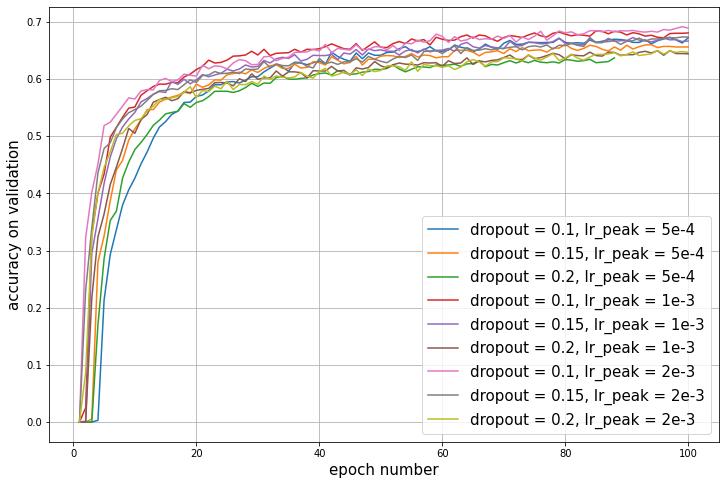

In [81]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(12, 8))
plt.plot(np.arange(len(acc_devs[1][:100])) + 1, acc_devs[1][:100], label='dropout = 0.1, lr_peak = 5e-4')
plt.plot(np.arange(len(acc_devs[10][:100])) + 1, acc_devs[10][:100], label='dropout = 0.15, lr_peak = 5e-4')
plt.plot(np.arange(len(acc_devs[11][:100])) + 1, acc_devs[11][:100], label='dropout = 0.2, lr_peak = 5e-4')

plt.plot(np.arange(len(acc_devs[4][:100])) + 1, acc_devs[4][:100], label='dropout = 0.1, lr_peak = 1e-3')
plt.plot(np.arange(len(acc_devs[7][:100])) + 1, acc_devs[7][:100], label='dropout = 0.15, lr_peak = 1e-3')
plt.plot(np.arange(len(acc_devs[9][:100])) + 1, acc_devs[9][:100], label='dropout = 0.2, lr_peak = 1e-3')

plt.plot(np.arange(len(acc_devs[5][:100])) + 1, acc_devs[5][:100], label='dropout = 0.1, lr_peak = 2e-3')
plt.plot(np.arange(len(acc_devs[6][:100])) + 1, acc_devs[6][:100], label='dropout = 0.15, lr_peak = 2e-3')
plt.plot(np.arange(len(acc_devs[8][:100])) + 1, acc_devs[8][:100], label='dropout = 0.2, lr_peak = 2e-3')

plt.ylabel('accuracy on validation', fontsize = 15)
plt.xlabel('epoch number', fontsize = 15)
plt.legend(fontsize=15)
plt.grid()
plt.show()


##3. Research part

It is proposed to implement an additional regularization method - **label smoothing**. To use it  CrossEntropy loss sometimes is replaced with Kullback-Leibler divergence, but now it is not necessary. Now imagine that we have a prediction vector from probabilities at position t in the sequence of tokens for each token id from the vocabulary. CrossEntropy compares it with ground truth one-hot representation [0, ... 0, 1, 0, ..., 0]. And now imagine that we are slightly "smoothed" the values in the ground truth vector and obtained [$\alpha/|V|$, ..., $\alpha/|V|$, $1-\alpha+\alpha/|V|$, $\alpha/|V|$, ... $\alpha/|V|$]. $\alpha$ - parameter from 0 to 1, $|V|$ - vocabulary size - number of components in the ground truth vector. The values ​​of this new vector are still summed to 1. Calculate the cross-entropy of our prediction vector and the new ground truth. Now, firstly, cross-entropy will never reach 0, and secondly, the result of the error function will require the model, as usual, to return the highest probability vector compared to other components of the probability vector for the correct token in the dictionary, but at the same time not too large, because as the value of this probability approaches 1, the value of the error function increases. For research on the use of label smoothing, see the [paper](https://arxiv.org/abs/1906.02629).
    
Accordingly, in order to embed label smoothing into the model, it is necessary to carry out the transformation described above on the ground truth vectors, as well as to implement the cross-entropy calculation, since the used `torch.nn.CrossEntropy` class is not quite suitable, since for the ground truth representation of `__call__` method takes the id of the correct token and builds a one-hot vector already inside. However, it is possible to implement what is required based on the internal implementation of this class [CrossEntropyLoss](https://pytorch.org/docs/stable/_modules/torch/nn/modules/loss.html#CrossEntropyLoss).
    

Test different values of $\alpha$ (e.x, 0.05, 0.1, 0.2). Describe your experiments and results.


```

ENTER HERE YOUR ANSWER

```